In [1]:
import random

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
    get_detection_dataset_dicts,
    build_detection_test_loader,
)
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode


from data_utils import read_split_file, register_dataset


/home/abhinavchadaga/miniforge3/envs/fri/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
im_paths = "data/panels/mixed/split.txt"
datasets = read_split_file(im_paths)
test_im_paths = datasets[-1]

In [3]:
DatasetCatalog.register("mixed_test", lambda im_paths=test_im_paths: register_dataset(im_paths=im_paths))
MetadataCatalog.get("mixed_test").thing_classes = ["label", "button"]
testset = get_detection_dataset_dicts("mixed_test", filter_empty=False)
len(testset)

20

In [4]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = "models/cascade_mask_rcnn_mixed/model_best.pth"
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.DATASETS.TEST = ("mixed_test",)

predictor = DefaultPredictor(cfg)

/home/abhinavchadaga/miniforge3/envs/fri/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068694/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


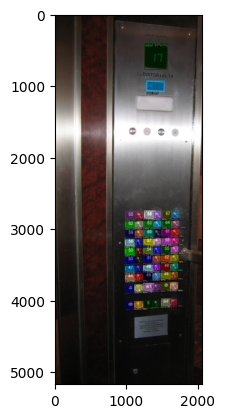

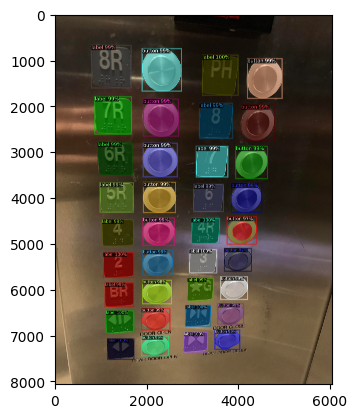

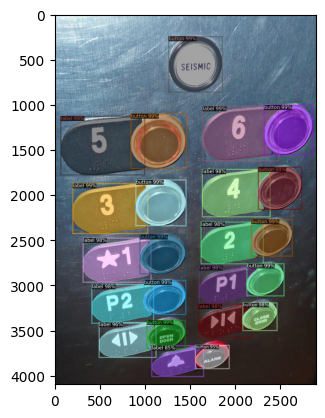

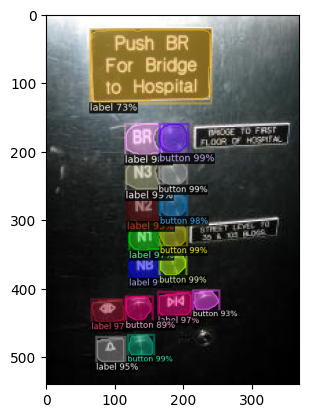

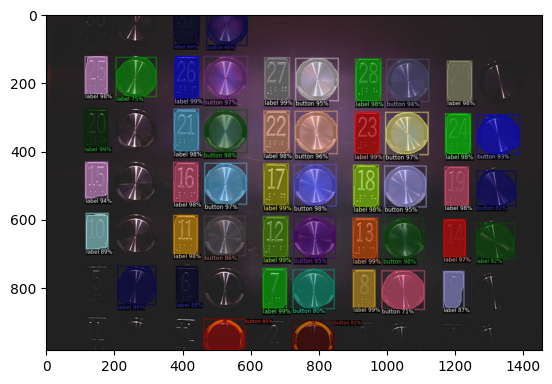

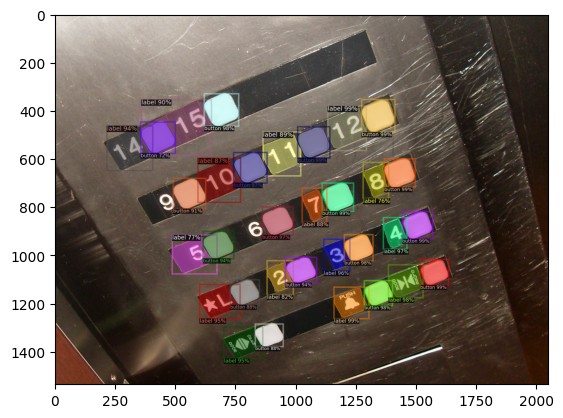

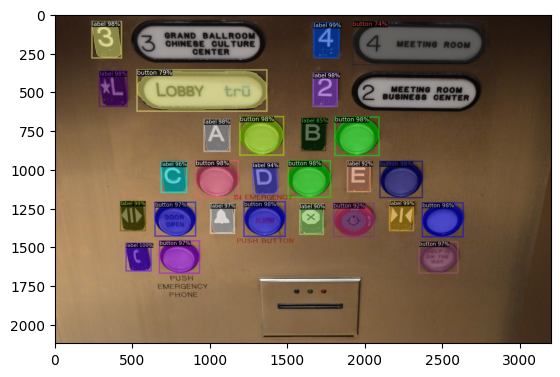

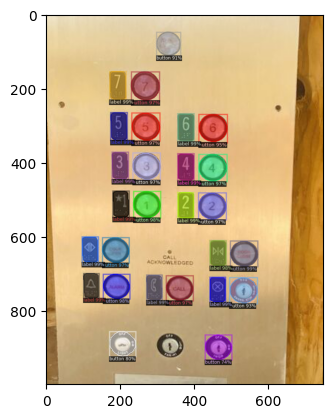

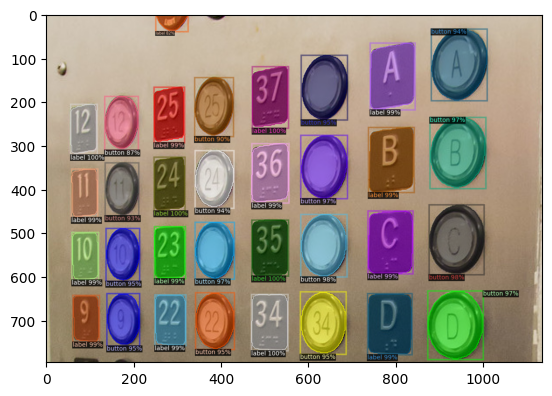

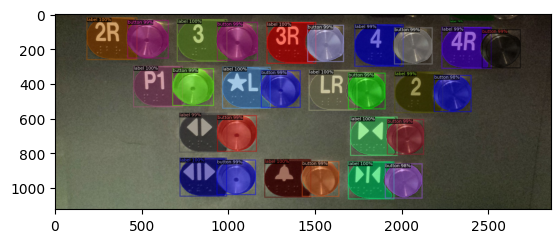

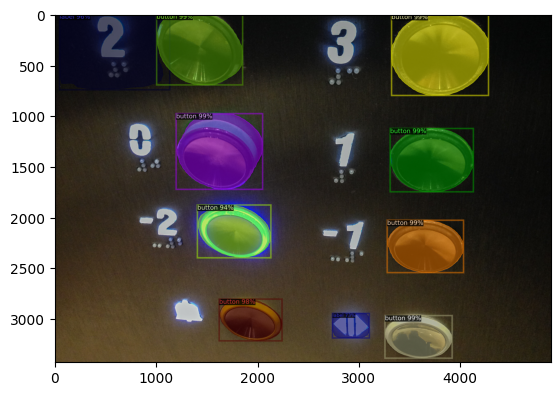

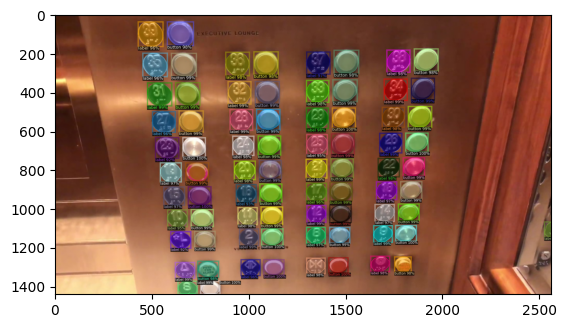

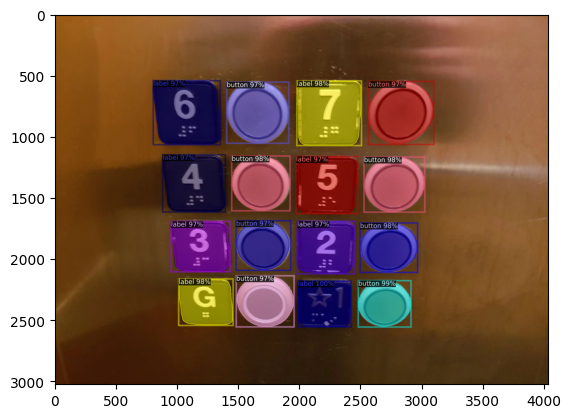

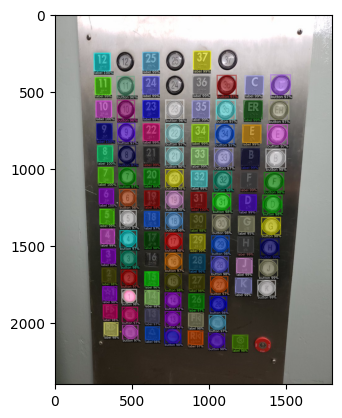

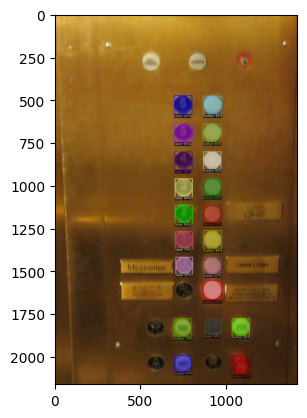

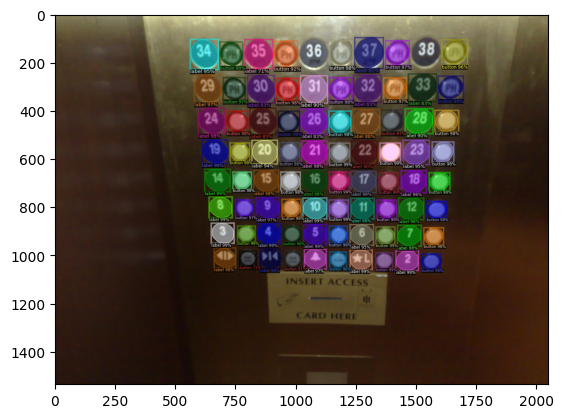

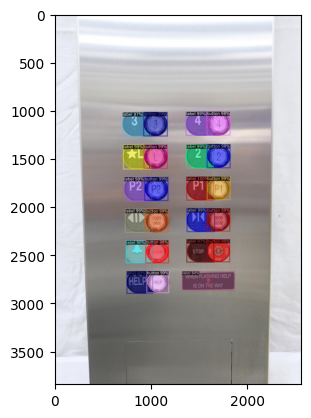

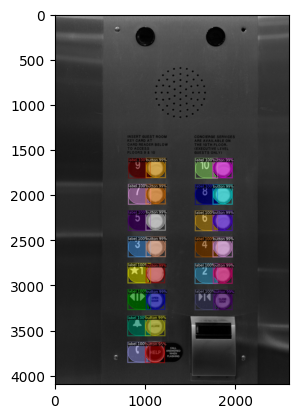

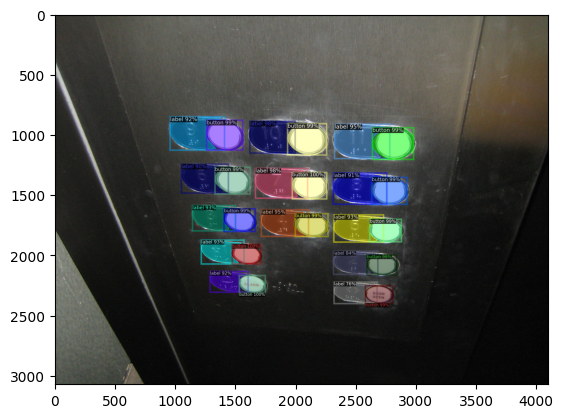

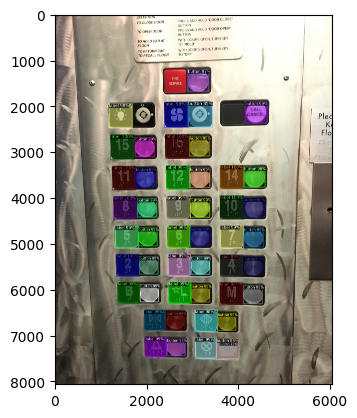

In [5]:
import os

output_dir = "test_images"
os.makedirs(output_dir, exist_ok=True)
for i, d in enumerate(testset):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(
        im[:, :, ::-1],
        metadata=MetadataCatalog.get("mixed_test"),
        scale=2.0,
        instance_mode=ColorMode.SEGMENTATION,
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    save_path = os.path.join(output_dir, os.path.basename(d['file_name']))
    cv2.imwrite(save_path, out.get_image()[:, :, ::-1])
    plt.imshow(out.get_image())
    plt.show()


In [6]:
evaluator = COCOEvaluator(
    "mixed_test",
    output_dir="./output",
    use_fast_impl=False,
    allow_cached_coco=False,
)
testloader = build_detection_test_loader(cfg, "mixed_test")
inference_on_dataset(predictor.model, testloader, evaluator)


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.19s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.932
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.893
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.817
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.762
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.793
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.044
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.421
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.822
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

OrderedDict([('bbox',
              {'AP': 76.7863140439112,
               'AP50': 93.19664972289353,
               'AP75': 89.26964309641605,
               'APs': 81.68507903421921,
               'APm': 76.15440323791265,
               'APl': 79.3459565837831,
               'AP-label': 76.22575962791744,
               'AP-button': 77.34686845990497}),
             ('segm',
              {'AP': 75.35067456444217,
               'AP50': 92.68910992817271,
               'AP75': 88.82610166028346,
               'APs': 69.89910157152211,
               'APm': 75.10010835955589,
               'APl': 79.3022187603067,
               'AP-label': 75.28326865103378,
               'AP-button': 75.41808047785055})])